In [1]:
import math
import h5py
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib.pyplot as plt
import time
import pandas as pd
import datetime
import random
import copy

import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import from_numpy
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from functools import partial

2.2.0+cu118


In [153]:
# importing data onto Google Colab
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

# TODO

Create 3 models for each region with exact same architecture (1 output neuron, no standardization needed)

Apply early stopping using validation set

Create time series plot of test data vs CNN vs El Nino plot with years for each region

Fourth person: think of creative architectures (potentially dropout?). Will be responsible for preparing real world data.

El Nino model with same train/val/test simulations


# CNN

### Prepare Data for CNN in PyTorch

In [2]:
ds2 = xr.open_dataset("Detrended_SST.nc", decode_times=False)
#ds2 = xr.open_dataset("/content/drive/MyDrive/CaliforniaClimateCapstone/Data/Detrended_SST.nc", decode_times=False)
ds2

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 7400)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 0 366 731 1096 1461 ... 25203 25568 25933 26298 26664
Data variables:
    SST      (time, lat, lon) float32 ...

In [3]:
PRECT = pd.read_csv('Detrended_PRECT.csv')
#PRECT = pd.read_csv('/content/drive/MyDrive/CaliforniaClimateCapstone/Data/Detrended_PRECT.csv')
PRECT = PRECT.set_index(['simulation', 'year', 'region'])
PRECT.head()

PRECT
simulation year region            
1001.001   1940 Central   1.696816
                North    -4.384861
                South     2.359652
           1941 Central   7.414276
                North    15.164542

In [4]:
y = PRECT.to_numpy()
y.shape

(22200, 1)

In [5]:
y = y.reshape(-1, 3)
y = y[:, 0]
y.shape

(7400,)

In [6]:
y_reshaped = y.reshape(100, 74, 1)
y_reshaped.shape

(100, 74, 1)

In [7]:
X = ds2['SST'].to_numpy()
X.shape

(7400, 192, 288)

In [8]:
X_reshaped = X.reshape(100, 74, 192, 288)
X_reshaped.shape

(100, 74, 192, 288)

In [9]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [10]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.1, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=.1/.9, random_state=49)

#Create Dataloader Objects for PyTorch
#BATCH_SIZE = 16
BATCH_SIZE = 32

X_train = from_numpy(X_train).float()
y_train = from_numpy(y_train).float()
X_val = from_numpy(X_val).float()
y_val = from_numpy(y_val).float()
X_test = from_numpy(X_test).float()
y_test = from_numpy(y_test).float()

print("After train/val/test split, before reshaping")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

X_train = X_train.view(-1, 192, 288)
X_test = X_test.view(-1, 192, 288)
X_val = X_val.view(-1, 192, 288)
y_train = y_train.view(-1, 1)
y_test = y_test.view(-1, 1)
y_val = y_val.view(-1, 1)

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

dataset_valid = TensorDataset(X_val, y_val)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False)

dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

#Check shape of resulting objects
print("After train/val/test split, after reshaping")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)


After train/val/test split, before reshaping
torch.Size([80, 74, 192, 288])
torch.Size([10, 74, 192, 288])
torch.Size([10, 74, 192, 288])
torch.Size([80, 74, 1])
torch.Size([10, 74, 1])
torch.Size([10, 74, 1])
After train/val/test split, after reshaping
torch.Size([5920, 192, 288])
torch.Size([740, 192, 288])
torch.Size([740, 192, 288])
torch.Size([5920, 1])
torch.Size([740, 1])
torch.Size([740, 1])


In [11]:
for batch in dataloader_train:
    predictor_batch, target_batch = batch
    print(predictor_batch.shape)
    break

torch.Size([32, 192, 288])


### Build CNN

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, stride = (2,2), kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 12 * 18, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # 1 output value

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 32 * 12 * 18)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model=Net()
model

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6912, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [13]:
# class DenseBlock(nn.Module):
#     def __init__(self, in_channels, growth_rate, num_layers):
#         super(DenseBlock, self).__init__()
#         self.layers = nn.ModuleList([self._make_dense_layer(in_channels + i * growth_rate, growth_rate)
#                                      for i in range(num_layers)])

#     def _make_dense_layer(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.BatchNorm2d(in_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#         )

#     def forward(self, x):
#         features = [x]
#         for layer in self.layers:
#             new_features = layer(torch.cat(features, 1))
#             features.append(new_features)
#         return torch.cat(features, 1)

# class TransitionBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(TransitionBlock, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
#         self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.pool(x)
#         return x

# class DenseNet(nn.Module):
#     def __init__(self, num_classes, growth_rate=32, block_config=(6, 12, 24, 16)):
#         super(DenseNet, self).__init__()
#         in_channels = 64
#         self.conv1 = nn.Conv2d(1, in_channels, kernel_size=7, stride=2, padding=3)
#         self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
#         # Dense blocks
#         self.dense1 = self._make_dense_block(in_channels, growth_rate, block_config[0])
#         in_channels += growth_rate * block_config[0]
#         self.trans1 = self._make_transition_block(in_channels, in_channels // 2)
#         in_channels = in_channels // 2
        
#         self.dense2 = self._make_dense_block(in_channels, growth_rate, block_config[1])
#         in_channels += growth_rate * block_config[1]
#         self.trans2 = self._make_transition_block(in_channels, in_channels // 2)
#         in_channels = in_channels // 2
        
#         self.dense3 = self._make_dense_block(in_channels, growth_rate, block_config[2])
#         in_channels += growth_rate * block_config[2]
#         self.trans3 = self._make_transition_block(in_channels, in_channels // 2)
#         in_channels = in_channels // 2
        
#         self.dense4 = self._make_dense_block(in_channels, growth_rate, block_config[3])
#         in_channels += growth_rate * block_config[3]
        
#         self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(in_channels, num_classes)
        
#     def _make_dense_block(self, in_channels, growth_rate, num_layers):
#         return DenseBlock(in_channels, growth_rate, num_layers)
    
#     def _make_transition_block(self, in_channels, out_channels):
#         return TransitionBlock(in_channels, out_channels)
    
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.pool1(x)
#         x = self.dense1(x)
#         x = self.trans1(x)
#         x = self.dense2(x)
#         x = self.trans2(x)
#         x = self.dense3(x)
#         x = self.trans3(x)
#         x = self.dense4(x)
#         x = self.avg_pool(x)
#         x = torch.flatten(x, 1)
#         x = self.fc(x)
#         return x

# # Example usage:
# # Create a DenseNet model with 121 layers
# model = DenseNet(num_classes=1, growth_rate=32, block_config=(6, 12, 24, 16))
# # Move model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# # Print model architecture
# print(model)


In [14]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 64, stride=(2, 2), kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm2d(32)
#         self.conv4 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
#         self.bn4 = nn.BatchNorm2d(16)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(16 * 6 * 9, 128)
#         self.bn5 = nn.BatchNorm1d(128)
#         self.fc2 = nn.Linear(128, 64)
#         self.bn6 = nn.BatchNorm1d(64)
#         self.fc3 = nn.Linear(64, 1)  # 1 output values

#     def forward(self, x):
#         x = self.pool(torch.selu(self.bn1(self.conv1(x))))
#         x = self.pool(torch.selu(self.bn2(self.conv2(x))))
#         x = self.pool(torch.selu(self.bn3(self.conv3(x))))
#         x = self.pool(torch.selu(self.bn4(self.conv4(x))))
#         x = x.view(-1, 16 * 6 * 9)
#         x = torch.selu(self.bn5(self.fc1(x)))
#         x = torch.selu(self.bn6(self.fc2(x)))
#         x = self.fc3(x)
#         return x

# model = Net()
# model

In [15]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

949217

In [16]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 500

### Train CNN

In [17]:
train_losses = []
valid_losses = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    epoch_loss = 0  # Initialize epoch loss
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X = X.unsqueeze(1)
        #X = X.to(device_cuda, non_blocking=True)
        #y = y.to(device_cuda, non_blocking=True)
        # Compute prediction and loss
        pred = model(X)

        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

        if batch % 36 == 0:
            loss, current = loss.item(), batch * BATCH_SIZE + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    epoch_avg_loss = epoch_loss / num_batches
    train_losses.append(epoch_avg_loss)


def test_valid_loop(dataloader, model, loss_fn, valid = True):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            # Prepare Data
            #X = X.to(device_cuda, non_blocking=True)
            #y = y.to(device_cuda, non_blocking=True)
            X = X.unsqueeze(1)
            # make predictions and calculate loss and accuracy
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    
    # Print either Validation or Test error
    if valid:
      print(f"Validation Loss: {test_loss:>8f} \n")
      valid_losses.append(test_loss)
    else:
      print(f"Test Loss: {test_loss:>8f} \n")

In [18]:
# Train model and evaluate on validation set for each epoch
best_loss = np.inf
patience = 10
no_improvement_counter = 0

for t in range(epochs):
    
    if no_improvement_counter > patience:
        break

    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader_train, model, loss_fn, optimizer)
    test_valid_loop(dataloader_valid, model, loss_fn)

    if valid_losses[t] < best_loss:
        best_loss = valid_losses[t]
        no_improvement_counter = 0
        #best_model_weights = model.state_dict().copy() # save best model
        best_model_weights = copy.deepcopy(model.state_dict())
    else:
        no_improvement_counter += 1
    
print("Done!")

Epoch 1
-------------------------------
loss: 19.540884  [   32/ 5920]
loss: 27.622795  [ 1184/ 5920]
loss: 19.213873  [ 2336/ 5920]
loss: 19.970608  [ 3488/ 5920]
loss: 17.078215  [ 4640/ 5920]
loss: 21.614561  [ 5792/ 5920]
Validation Loss: 21.969207 

OrderedDict([('conv1.weight', tensor([[[[-7.2777e-02,  6.8037e-02, -1.6199e-01],
          [ 1.9581e-01,  2.9334e-01, -2.4469e-01],
          [ 2.8956e-01,  6.2829e-02,  2.4642e-01]]],


        [[[ 4.5994e-02,  1.6162e-01, -4.6035e-02],
          [ 2.5732e-01,  4.9901e-02, -1.5496e-01],
          [ 8.4821e-02, -1.5400e-01, -3.8519e-02]]],


        [[[-1.3529e-01,  2.2156e-01, -2.6243e-01],
          [-1.5347e-01, -9.3888e-02, -1.9973e-01],
          [ 3.1473e-02, -3.3020e-01,  3.0138e-01]]],


        [[[-2.8092e-01,  2.5942e-01,  5.7900e-02],
          [-1.0592e-01,  2.0834e-01,  5.4321e-02],
          [ 2.7102e-01,  3.9050e-02, -1.0383e-01]]],


        [[[ 8.8729e-02, -9.0840e-02,  1.3941e-01],
          [ 2.9664e-01,  1.9164e-01,

KeyboardInterrupt: 

### Evaluate CNN

In [24]:
def r_squared(actual, predicted):
    # Calculate mean of actual values
    mean_actual = np.mean(actual)
    
    # Calculate sum of squared differences between actual and predicted values
    ss_residual = np.sum((actual - predicted) ** 2)
    
    # Calculate sum of squared differences between actual and mean values
    ss_total = np.sum((actual - mean_actual) ** 2)
    
    # Calculate R-squared
    r2 = 1 - (ss_residual / ss_total)
    
    return r2



actual_values = np.array(y_test.squeeze(1))

# Instantiate model
model_best_weights = Net()
#model_best_weights = DenseNet(num_classes=1, growth_rate=32, block_config=(6, 12, 24, 16))

# Load the best model weights
model_best_weights.load_state_dict(best_model_weights)

# Set the model to evaluation mode
model_best_weights.eval()
#model.eval()
predicted_values = model_best_weights(X_test.unsqueeze(1)).squeeze(1).detach().numpy()
#predicted_values = model(X_test.unsqueeze(1)).squeeze(1).detach().numpy()

r_squared_value = r_squared(actual_values, predicted_values)
print("R-squared:", r_squared_value)

R-squared: 0.007800102233886719


In [53]:
test_valid_loop(dataloader_test, model_best_weights, loss_fn, valid = False)
#test_valid_loop(dataloader_test, model, loss_fn, valid = False)

Test Loss: 22.244356 



In [25]:
pred_dict = dict()
pred_dict2 = dict()

for i in range(1940, 2014):
    pred_dict[i] = actual_values[i - 1940]
    pred_dict2[i] = predicted_values[i - 1940]

actual_df = pd.DataFrame(list(pred_dict.items()), columns=['Year', 'Actual PRECT'])
pred_df = pd.DataFrame(list(pred_dict2.items()), columns=['Year', 'Predicted PRECT'])

# Merge the DataFrames on 'Epoch' column
actual_pred_df = pd.merge(actual_df, pred_df, on='Year')

#actual_pred_df


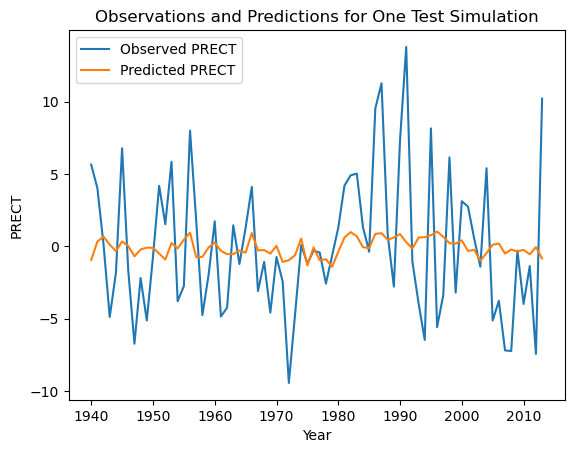

In [26]:
plt.plot(actual_pred_df['Year'], actual_pred_df['Actual PRECT'], label='Observed PRECT')
plt.plot(actual_pred_df['Year'], actual_pred_df['Predicted PRECT'], label='Predicted PRECT')
plt.xlabel('Year')
plt.ylabel('PRECT')
plt.title('Observations and Predictions for One Test Simulation')
plt.legend()
plt.show()

In [45]:
train_losses

[23.162566293252482,
 23.128082234150654,
 22.999356733786094,
 22.857300943941684,
 22.718893473857158,
 22.584144494340226,
 22.369866829949455,
 22.132180590242953,
 21.91183364971264,
 21.602608639485126,
 21.080478119205782,
 20.535206774118784]

In [46]:
valid_losses

[21.97923505306244,
 22.05652316411336,
 22.406926155090332,
 22.59624703725179,
 22.52506947517395,
 22.60541884104411,
 23.018566370010376,
 23.297894835472107,
 23.511165142059326,
 23.452694137891132,
 23.81409768263499,
 24.429672757784527]

In [47]:
train_loss_dict = dict()

valid_loss_dict = dict()

for i in range(len(train_losses)):
    train_loss_dict[i+1] = train_losses[i]
    valid_loss_dict[i+1] = valid_losses[i]

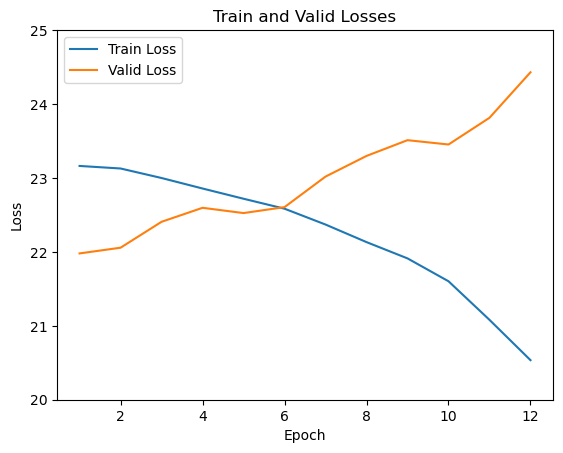

In [48]:
train_loss_df = pd.DataFrame(list(train_loss_dict.items()), columns=['Epoch', 'Train Loss'])
valid_loss_df = pd.DataFrame(list(valid_loss_dict.items()), columns=['Epoch', 'Valid Loss'])

# Merge the DataFrames on 'Epoch' column
merged_df = pd.merge(train_loss_df, valid_loss_df, on='Epoch')

# Plot the losses
plt.plot(merged_df['Epoch'], merged_df['Train Loss'], label='Train Loss')
plt.plot(merged_df['Epoch'], merged_df['Valid Loss'], label='Valid Loss')
plt.ylim(20, 25)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Valid Losses')
plt.legend()
plt.show()